## 0. Import Libraries

In [36]:
from glob import glob
from metpy.units import units

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

## 1. Parameters

In [106]:
# CHANGE BELOW!
# variable name
name_var = 'tp'

# ----------------------
# general path
path_general = 'data'

# data path
path_data = glob(fr'{path_general}/{name_var}*')[0]

# units to convert
unit_convert = {
    't2m':'degC',
    'blh':'m',
    'cbh':'m',
    'tp':'mm'
}

In [107]:
path_data

'data/tp_era5_2001_2020.nc'

## 2. Open Data

In [108]:
# find datasets using glob
dt_era5 = xr.open_dataset(path_data)[name_var]

# assign units
dt_era5 = dt_era5 * units(dt_era5.attrs['units'])

In [109]:
dt_era5

Magnitude,[[[0.0 0.0 0.0 ... 1.130625605583191e-06 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] ... [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 3.771856427192688e-07 3.771856427192688e-07] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 3.3909454941749573e-06 3.3909454941749573e-06] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]] [[0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 2.261251211166382e-06 2.261251211166382e-06] ... [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0] [0.0 0.0 0.0 ... 0.0 0.0 0.0]]]
Units,meter


## 3. Aggregation

In [110]:
# for month-hour agg
dt_era5.coords['monthhour'] = (
    ('time', ),
    pd.MultiIndex.from_arrays([dt_era5.time.dt.month.values, dt_era5.time.dt.hour.values])
                             )

### 3.1 Month-Hourly

In [130]:
# agg type
type1 = 'month'
type2 = 'hour'
type_agg = type1 + type2

# unit conversion
# group by hour of each month
# unstack e.g., 72 to (3, 24) --> 3 months 24 hours..

# sum for tp
if name_var == 'tp':
    dt_agg = dt_era5.metpy\
                        .convert_units(unit_convert[name_var])\
                        .groupby(type_agg)\
                        .sum(dim='time')\
                        .unstack({type_agg})\
                        .rename({fr'{type_agg}_level_0':type1,
                                 fr'{type_agg}_level_1':type2})\
                        .transpose(type1, type2, 'latitude', 'longitude')
    
# mean for others
else:
    dt_agg = dt_era5.metpy\
                        .convert_units(unit_convert[name_var])\
                        .groupby(type_agg)\
                        .mean(dim='time')\
                        .unstack({type_agg})\
                        .rename({fr'{type_agg}_level_0':type1,
                                 fr'{type_agg}_level_1':type2})\
                        .transpose(type1, type2, 'latitude', 'longitude')

# save to netcdf file
dt_agg.to_netcdf(fr'{path_general}/aggregated_{name_var}_era5_{type_agg}')

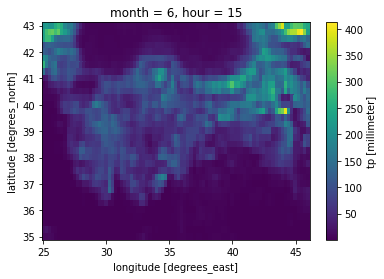

In [132]:
dt_agg[0][15].plot()